# Разработка стратегии взаимодействия сети фитнес-центров "Культурист-датасаентист" с пользователями на основе аналитических данных

**Цель проекта** - провести анализ и подготовить план действий по удержанию клиентов, а именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
	
    1) выделить целевые группы клиентов;
    
	2) предложить меры по снижению оттока;
    
	3) определить другие особенности взаимодействия с клиентами.

**Описание данных**

-	'Churn' — факт оттока в текущем месяце;

Текущие поля в датасете:

1) Данные пользователя за предыдущий до проверки факта оттока месяц:

- 'gender' — пол;

-	'Near_Location' — проживание или работа в районе, где находится фитнес-центр;

-	'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);

-	Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);

-	'Phone' — наличие контактного телефона;

-	'Age' — возраст;

-	'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах);

2)	Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

-	'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);

-	'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);

-	'Group_visits' — факт посещения групповых занятий;

-	'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;

-	'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;

-	'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Знакомство-с-данными-из-файла" data-toc-modified-id="Знакомство-с-данными-из-файла-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Знакомство с данными из файла</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Построение-модели-прогнозирования-оттока-пользователей" data-toc-modified-id="Построение-модели-прогнозирования-оттока-пользователей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Построение модели прогнозирования оттока пользователей</a></span></li><li><span><a href="#Кластеризация-пользователей" data-toc-modified-id="Кластеризация-пользователей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Кластеризация пользователей</a></span></li><li><span><a href="#Выводы-и-рекомендации" data-toc-modified-id="Выводы-и-рекомендации-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы и рекомендации</a></span></li></ul></div>

## Знакомство с данными из файла

In [1]:
import pandas as pd
pd.set_option('max_colwidth', -1)
pd.options.display.float_format = '{:,.2f}'.format

import numpy as np
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from scipy import stats as st

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Датасет содержит данные по 14ти признакам (числовые и категориальные, которые преобразованы в числовые) о 4000 клиентах. Тип данных корректен. Пропущенных нет (это хорошо). Приведем наименования столбцов к единому виду - нижний регистр. Проверим на дубликаты, удалим их, если есть, и в путь.

## Предобработка данных

In [4]:
df.columns = df.columns.str.lower() 

In [5]:
df.duplicated().sum()

0

In [6]:
df.head(10)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0
5,1,1,0,0,1,1,1,34,450.74,1.00,3,2.62,2.64,0
6,1,1,1,1,0,6,1,32,94.27,6.00,2,1.14,1.28,0
7,0,1,0,0,1,1,0,30,217.79,1.00,0,1.21,1.05,1
8,1,1,1,1,1,1,1,23,45.41,1.00,1,1.11,1.06,0
9,0,1,0,0,1,1,0,31,65.31,1.00,11,1.81,1.95,0


Отсутствующих признаков нет. Изучим средние значения и стандартные отклонения методом describe().

## Исследовательский анализ данных

In [7]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Здесь можно сделать следующие выводы:

- по половому признаку массив данных разделился почти пополам;
- основная масса "культуристов" живут рядом с фитнес-центром;
- почти половина посетителей - сотрудники партнеров фитнес-центра;
- только 30% пришли по рекомендации друзей;
- данные о контактном мобильном телефоне присутствуют только у 90% пользователей;
- средняя продолжительность текущего абонемента 4,7 мес;
- групповые занятия посещали лишь 41%, остальные 59% - индивидуалы;
- средний возраст клиента 29 лет;
- средняя выручка от дополнительных услуг центра 147 у.е.;
- в среднем до конца абонемента осталось 4 месяца
- среднее время с момента первого обращения в фитнес-центр составляет почти 4 месяца (этому может быть причиной либо "молодость" самого фитнес-центра, либо недавно "пошел" клиент, либо ошибка обработки анкет);
- частота посещения в неделю держится ровно по представленным двум месяцам;
- отток клиента составляет 27%.

Посмотрим на средние значения признаков двух групп - тех, кто ушел в отток, и тех, кто остался.

In [8]:
df.groupby('churn').agg('mean').T.style

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.74719,1.72856
group_visits,0.464103,0.268615
age,29.9765,26.9896
avg_additional_charges_total,158.446,115.083
month_to_end_contract,5.28309,1.66258


In [9]:
clients_no_churn = df.query('churn <= 0')
clients_churn = df.query('churn != 0')

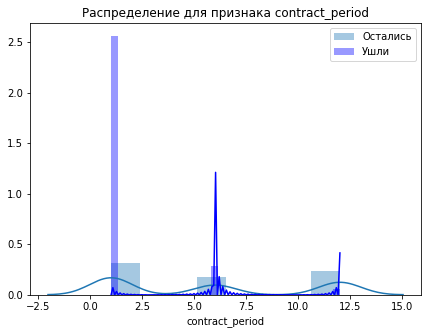

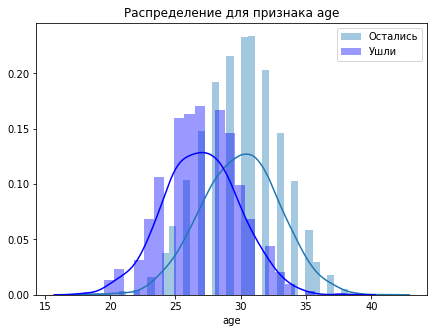

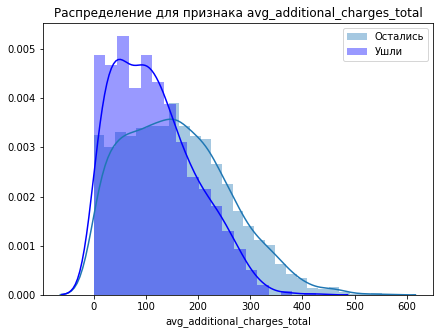

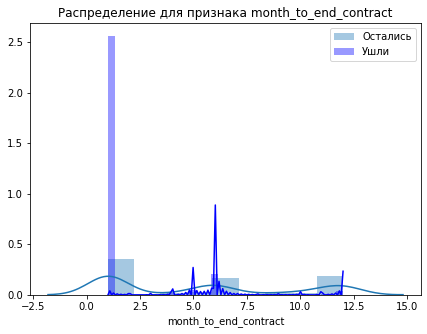

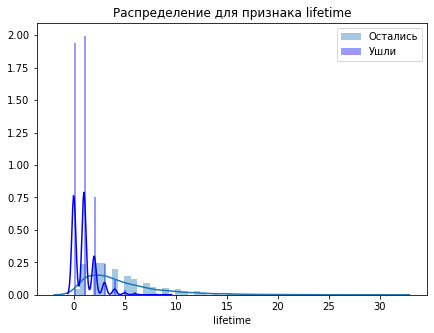

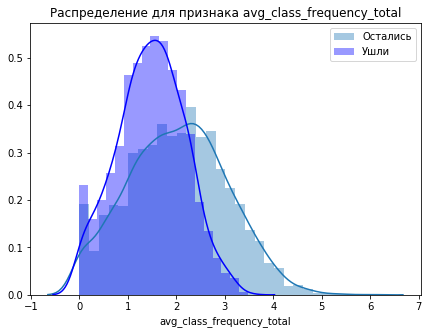

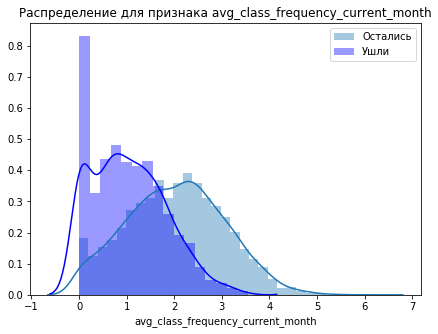

In [10]:
num_feat = df.drop(columns =(['gender', 'near_location', 
                              'partner','promo_friends', 'phone',
                              'group_visits', 'churn'])).columns
for col in num_feat:
    plt.figure(figsize=(7, 5))
    sns.distplot(clients_no_churn[col])
    sns.distplot(clients_churn[col], color = 'b')
    plt.legend(labels = ('Остались', 'Ушли'))
    plt.title('Распределение для признака ' + col)
    plt.show()

- Молодые уходят чаще, чем взрослые
- Ушедшие клиенты тратят меньше
- Клиенты в оттоке, в основном, покупают абономент на один месяц
- Уходят только новички, если клиент проходил в зал больше 5 месяцев, то его уход почти равен нулю
- Клиенты в оттоке чаще всего посещают зал от 1 до 2 раз в неделю
- Если клиент ниразу не посетил зал за месяц, то вероятнее всего он больше не вернется, если же посетил зал больше 4-х раз, то вероятнее всего он станет постоянным клиентом

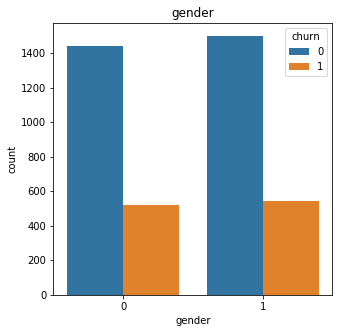

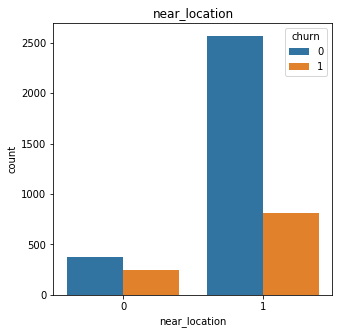

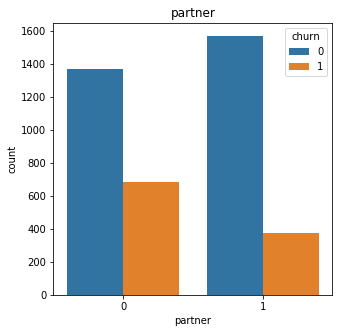

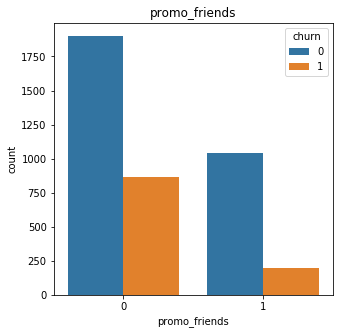

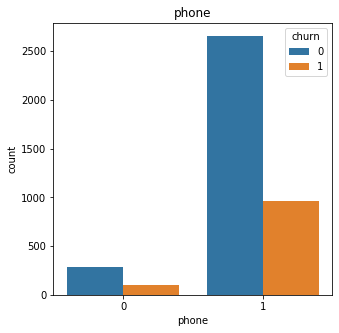

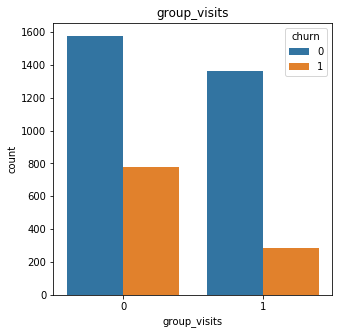

In [11]:
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = df[column], hue='churn', data=df)
    plt.title(column)
    plt.show()       

Среди ушедших:
- одинаковое количество мужчин и женщин;
- близко живут к фитнес-центру;
- только 35% пришли по партнерской программе и  18% по рекомендации друзей;
- абонемент куплен на небольшое количество месяцев (не больше 3х при условии, что на 2 месяца абонементов нет);
- до 30% от общего оттока посещали групповые занятия;
- средний возраст 27 лет;
- срок посещений - не больше месяца.

In [12]:
cm = df.corr()

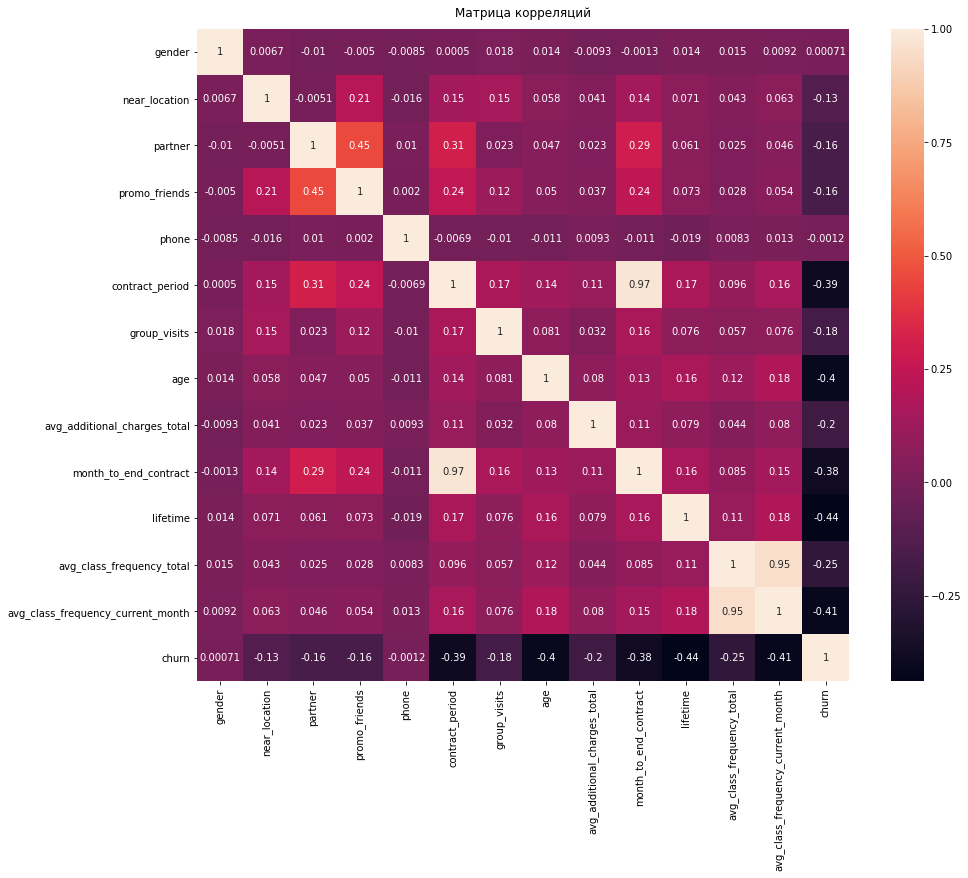

In [13]:
plt.figure(figsize=(15, 12))
heatmap = sns.heatmap(cm, annot=True, square=True)
heatmap.set_title('Матрица корреляций', fontdict={'fontsize':12}, pad=12);

**Есть мультиколлинеарные признаки:**
- contract_period - month_to_end_contract;
- avg_class_frequency_current_month - avg_class_frequency_total.

**Есть признаки с нулевой корреляцией с целевой переменной:**
- phone;
- gender.

## Построение модели прогнозирования оттока пользователей

In [14]:
X = df.drop('churn', axis = 1)
y = df['churn']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

**Нормализуем данные**

In [16]:
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

**Обучим модель на train-выборке двумя способами:**
1. Логистической регрессией

In [17]:
# зададим алгоритм для нашей модели
model = LogisticRegression(random_state=0)

# обучим модель
model.fit(X_train_st, y_train)

# воспользуйтесь уже обученной моделью, чтобы сделать прогнозы

predictions = model.predict(X_test_st)

"""model.predict_proba(X_test) выдаёт вектор пар значений, где первое значение соответствует вероятности отнесения 
к первому ("0") классу, а второе — ко второму ("1"). Чтобы получить вектор вероятностей отнесения ко второму ("1") классу,
обратитесь по индексу — model.predict_proba(X_test)[:,1] """

probabilities = model.predict_proba(X_test_st)[:,1]

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



2. Случайным лесом

In [18]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

**Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели. Покажем, какая модель показала себя лучше на основании метрик.**

In [19]:
#Функция для вывода метрик обучающих моделей
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации '):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))    

In [20]:
# выведем все метрики
print_all_metrics(y_test, predictions, probabilities, title = 'Метрики для модели  логистической регрессии:')

print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')

Метрики для модели  логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81


**C небольшим преимуществом логистическая регрессия выглядит лучше.**

## Кластеризация пользователей

In [21]:
df_sс = df.drop(['churn'], axis=1)
df_columns_list = df_sс.columns
df_sс = StandardScaler().fit_transform(df_sс)
df_sс = pd.DataFrame(df_sс, columns = df_columns_list).astype('float64')

In [22]:
linked = linkage(df_sс, method = 'ward')

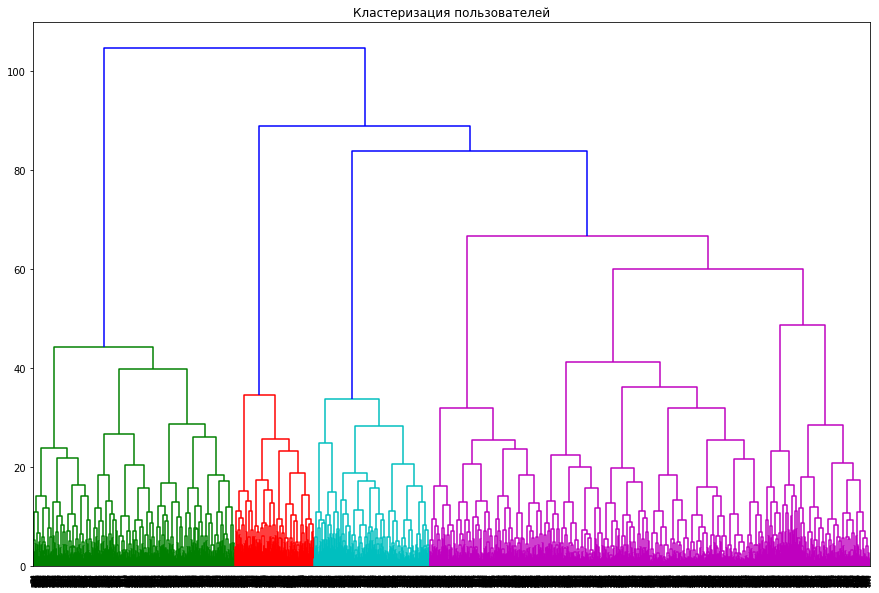

In [23]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation = 'top')
plt.title('Кластеризация пользователей')
plt.show()

Вывод: можно выделить 4 кластера.

In [24]:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(df_sс)
df['cluster'] = labels

In [25]:
df.groupby(['cluster']).mean().T

cluster,0,1,2,3,4
gender,0.50,0.52,0.50,0.49,0.56
near_location,0.96,0.86,0.00,1.00,0.98
partner,0.78,0.47,0.46,0.35,0.36
promo_friends,0.57,0.31,0.08,0.24,0.23
phone,1.00,0.00,1.00,1.00,1.00
contract_period,10.88,4.79,2.35,1.95,2.67
group_visits,0.54,0.43,0.22,0.34,0.47
age,29.98,29.30,28.48,28.17,30.13
avg_additional_charges_total,160.71,143.96,135.46,131.62,161.72
month_to_end_contract,9.95,4.48,2.20,1.86,2.46


**Вывод**

ТОП-3 оттока пользователей:
- 3;
- 2;
- 1.

Это самые молодые кластеры с наименьшим "сроком" жизни взаимодействия ФЦ-клиент, соответственно, и с наименьшим размером выручки и с частотой посещения в неделю - до 2х раз.

Кластеры с низким оттоком (0 и 4), так называемые, надежные клиенты, характеризуются:
- возрастом выше;
- большим сроком взаимодействия с фитнес-центром;
- большей выручкой;
- большей частотой посещения (ближе к 2м и не больше 3х).

In [26]:
#посмотрим на датасет
df.head(5)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0,1
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0,3
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0,3


In [27]:
#В данных есть бинарные и небинарные признаки. Разделим их на разные датасеты.
non_binary = df.drop(columns =(['gender', 'near_location', 
                              'partner','promo_friends', 'phone',
                              'group_visits', 'churn', 'cluster']))
binary = df[['gender', 'near_location', 
                              'partner','promo_friends', 'phone',
                              'group_visits']]

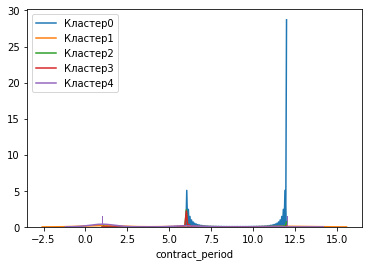

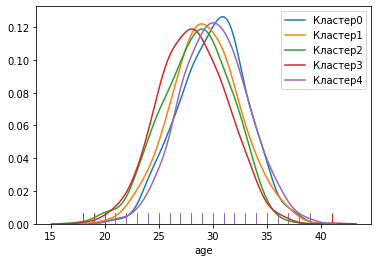

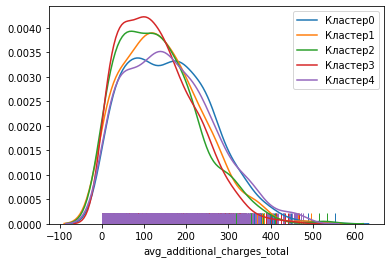

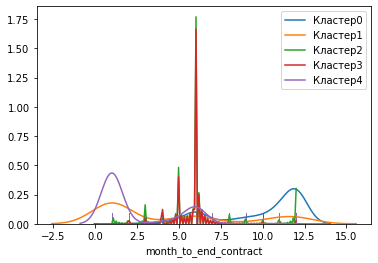

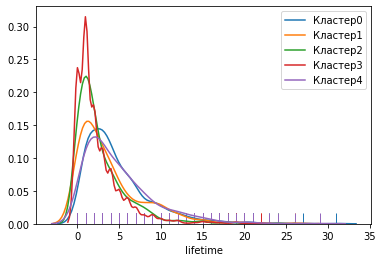

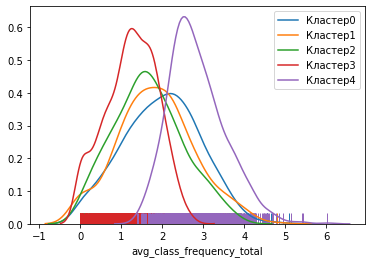

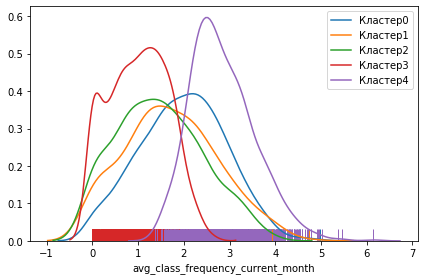

In [28]:
for col in non_binary:
    plt.figure()
    for i in range(0,5):
        sns.distplot(df.query('cluster == @i')[col],
                    hist=False,
                    rug=True,
                    kde_kws={'label':'Кластер'+ str(i)})
plt.tight_layout()

**Выводы на основе графиков подтверждаются:**
Больше всего склонны к оттоку молодые ребята, на пике 28-29 лет, а надежные кластеры самые возрастные 0-й кластер на пике 31 год, 4-й на пике 30 лет.
По длительности контракта лучше себя показывают ребята из кластера 0 (приближается к 12 мес).
Более надежные кластеры дают бОльшую выручку.
Самый активный кластер 4-й, в среднем 3 посещения в неделю. Минимальная активность наблюдается у 3-го кластера - в среднем 1 занятие в неделю. Чем клиент активнее в течение недели посещает зал, тем меньше вероятность его оттока.
Месячная посещаемость, в целом, схожа с динамикой посещений в неделю.

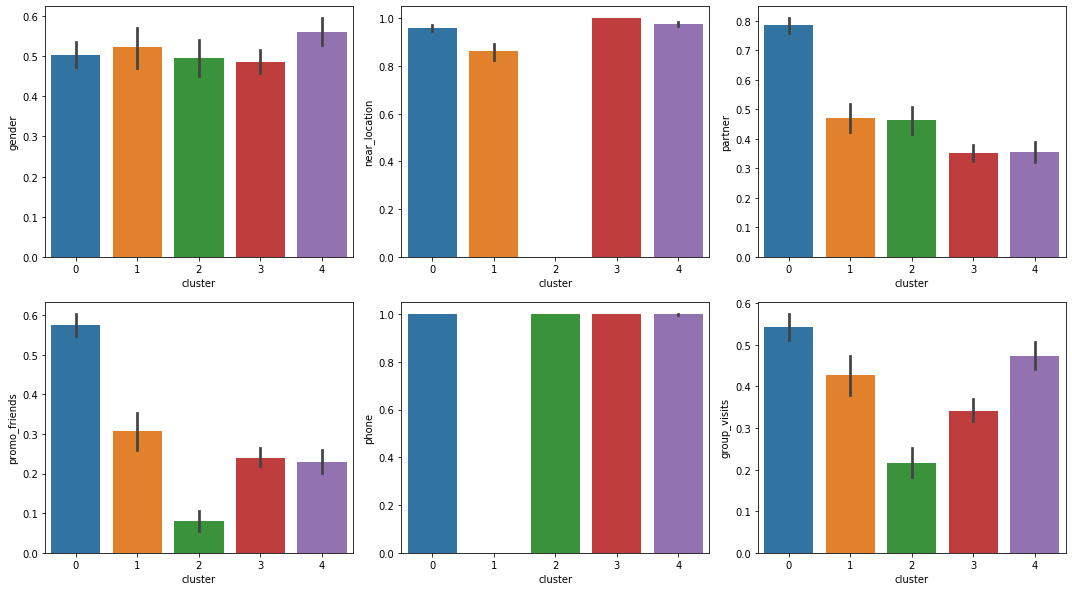

In [29]:
plt.figure(figsize=(15,12))
for i in range(len(binary.columns)):
    plt.subplot(3,3,i+1)
    x = df['cluster']
    y = binary.iloc[:,i]
    sns.barplot(x=x, y=y)
plt.tight_layout()
plt.show()

**Выводы:**

- клиенты кластера 2 проживают вдали от фитнес-центра. Вероятно, это стало одной из причин оттока.
- в "надежных" кластерах 0 и 4 по-разному пользователи распределились в отношении партнерской программы. Так, основная часть клиентов 4го кластера в нее не входят.
- клиенты одного из "надежных" кластеров (0) в большей степени - по рекомендации друзей. А в "ненадежном" 2м кластере клиенты воспользовались рекламной акцией фитнес-центра и ушли. 
- клиенты практически всех кластеров оставили свои телефоны, однако "выделились" клиенты 1го кластера - телефонов нет.
- групповые занятия чаще всего посещают пользователи кластера 0. Скорее всего это женщины на занятиях йоги, пилатеса и пр.

In [30]:
#Для каждого полученного кластера посчитаем долю оттока.
for clast in range(0, 5):
    df_int = df.loc[df['cluster'] == clast, ['churn']]
    df_int_avg = round(df_int.loc[df_int['churn'] == 1].shape[0]/df_int.shape[0]*100, 2)
    print('Доля оттока посетителей в кластере', clast, '-', df_int_avg, '%')

Доля оттока посетителей в кластере 0 - 2.77 %
Доля оттока посетителей в кластере 1 - 26.75 %
Доля оттока посетителей в кластере 2 - 44.36 %
Доля оттока посетителей в кластере 3 - 51.43 %
Доля оттока посетителей в кластере 4 - 6.81 %


In [31]:
#Посчитаем долю каждого кластера в общем обьеме
for clast_part in range(0, 5):
    df_int_part = round(df[df['cluster'] == clast_part].shape[0]/df.shape[0]*100, 2)
    print('Доля  кластера', clast_part, '-', df_int_part, '%')

Доля  кластера 0 - 25.27 %
Доля  кластера 1 - 9.62 %
Доля  кластера 2 - 12.62 %
Доля  кластера 3 - 31.55 %
Доля  кластера 4 - 20.93 %


Выводы подтвердились: наиболее надежные кластеры - 0 и 4. К сожалению, это всего лишь 46,2% клиентов.

##  Выводы и рекомендации

**Первым делом стоит обратить большее внимание на новых клиентов, так как эти клиенты наиболее подвержены оттоку. А так же на то, что их траты ниже всех остальных кластеров, именно поэтому для новых клиентов нужно создать акции и дополнительные скидки на первое время, чтобы удержать их. Так же они чаще вего покупают абонеменет на один месяц, наверняка чтобы разведать обстановку, здесь-то и нужно их заинтересовать, возможно нужно предложить только для новых клиентов абономент на 3 месяца + возможность посетить платные занятие бесплатно или пустить в зону "вип-клиентов" (если таковая имеется), так они смогу познакомиться с уже постоянными клиентами, а это очень важно. Так же нужно уделить внимание акции "Приведи друга" и для новых клиентов, кто купил абонемент, например не на 1 месяц, а на 12, он получит дополнительный абонемент для друга бесплатно. В остальном же постоянные клиенты имеют гиппер минимальную склонность к оттоку, но так же имеют тенденцию покупать абонемент на один месяц, стоить создать программу лояльности, таким образом уменьшится вероятность оттока постоянных клиентов!**